# PCA vs HOPCA

I will write the comments in italian because I truly believe that very few people other than me will read it. If this is an issue tell me and I will translate everything

## Scopo

Lo scopo e' quello di confrontare PCA con la sua versione tensoriale. Questo notebook parte come un proof of concept, quindi per ora lo faccio per 1 solo numero di reynolds (8000) con forte subsampling e vedo se ci sono differenze

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
from utils import print_statistics, load_dataset, scale_and_center_tensors


In [2]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-8000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
# Load metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)

Nx, Ny = metadata['global']['Nxyz']

# Load grid
X_filename = metadata['global']['grid']['x']
Y_filename = metadata['global']['grid']['y']
X = np.fromfile(data_paths[0] + '/' + X_filename, dtype='<f4').reshape(Ny, Nx)
Y = np.fromfile(data_paths[0] + '/' + Y_filename, dtype='<f4').reshape(Ny, Nx)

# Subsample grid
X_sub = X[::subsample_x, ::subsample_y]
Y_sub = Y[::subsample_x, ::subsample_y]
Ny_sub, Nx_sub = X_sub.shape

print(f"Original grid: ({Nx}, {Ny})")
print(f"Subsampled grid: ({Nx_sub}, {Ny_sub})")

Original grid: (1600, 2000)
Subsampled grid: (160, 200)


In [3]:
component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']

# Molar masses (g/mol)
molar_masses = {
    'YH': 1.0,
    'YH2': 2.0,
    'YO': 8.0,
    'YO2': 16.0,
    'YOH': 9.0,
    'YH2O': 10.0,
    'YHO2': 17.0,
    'YH2O2': 18.0
}


file_key_map = {
    'YH': 'YH filename',
    'YH2': 'YH2 filename',
    'YO': 'YO filename',
    'YO2': 'YO2 filename',
    'YOH': 'YOH filename',
    'YH2O': 'YH2O filename',
    'YHO2': 'YHO2 filename',
    'YH2O2': 'YH2O2 filename'
}

In [4]:

tensors = {path: load_dataset(path, component_names, file_key_map, Ny=Ny, Nx=Nx, n_snapshots=n_snapshots, molar_masses=molar_masses, subsample_x=10, subsample_y=10)
           for path in data_paths}


  Available components in dataset: ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']


In [5]:
print_statistics(tensors, component_names=component_names)


Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              2.108595e-04 4.958064e-04 -4.988369e-25 4.876255e-03
YH2             3.141716e-02 8.368027e-02 0.000000e+00 3.249700e-01
YO              8.207165e-05 2.683234e-04 -1.025646e-14 1.899564e-03
YO2             1.125224e-02 5.756119e-03 1.262478e-07 1.456250e-02
YOH             1.605751e-04 5.228729e-04 -1.954558e-11 3.019940e-03
YH2O            3.061480e-03 6.672779e-03 -2.330029e-07 2.365345e-02
YHO2            2.972886e-07 8.293629e-07 -2.481960e-17 1.084706e-05
YH2O2           1.741783e-08 4.961067e-08 -8.167948e-13 7.718936e-07
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mean: 5.773

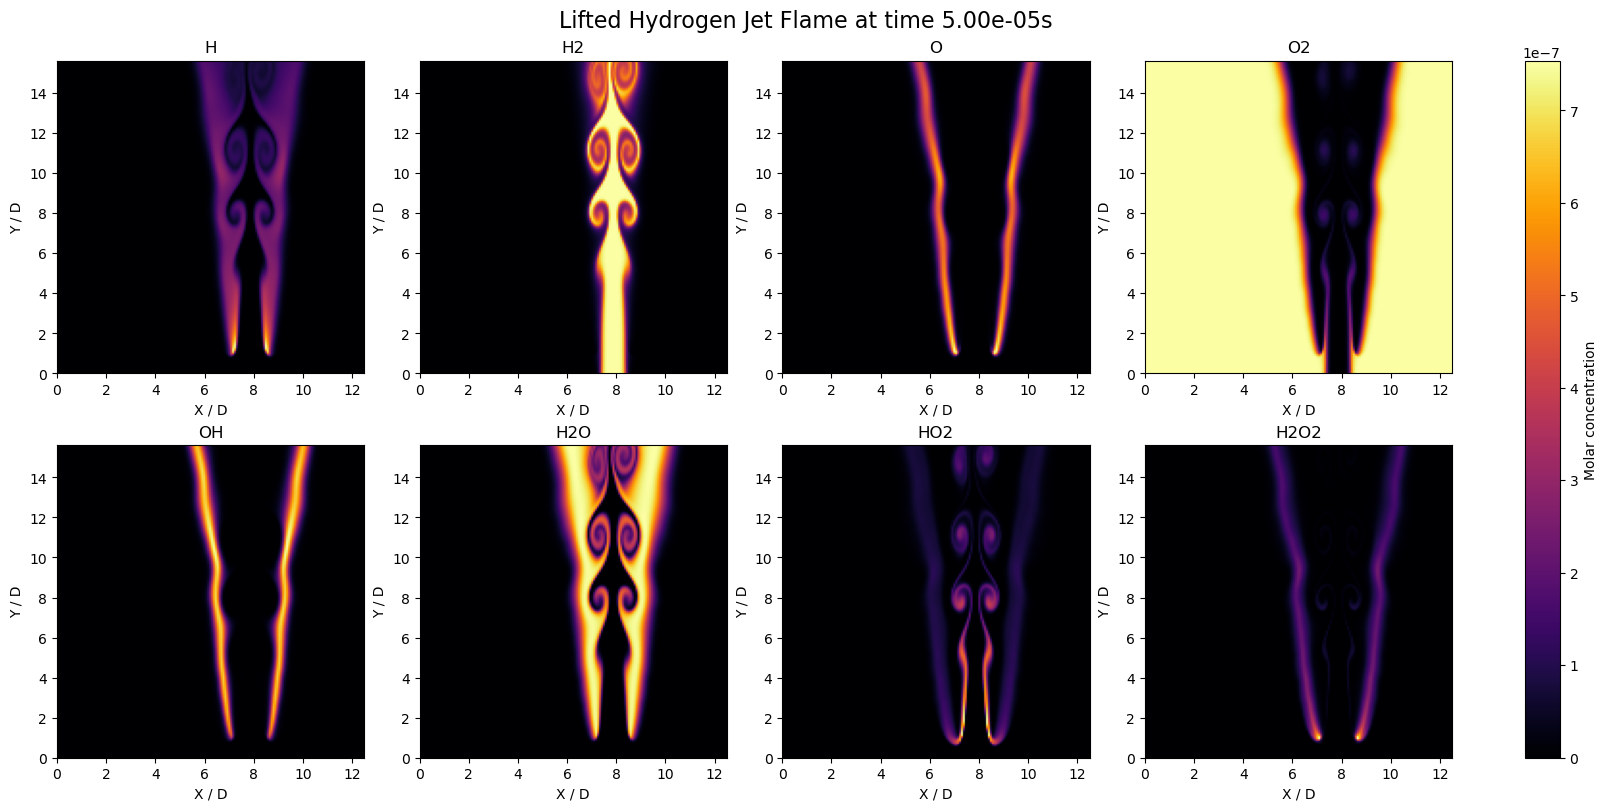

In [6]:
import matplotlib.pyplot as plt
import numpy as np

Lx, Ly = 12.5, 15.6        # domain size in D units
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()
key, tensor = next(iter(tensors.items()))
for idx, ax in enumerate(axes):
    if idx < tensor.shape[2]:
        im = ax.imshow(
            tensor[:, :, idx, t],
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        ax.set_title(f"{component_names[idx][1:]}")
        ax.set_xlabel("X / D")
        ax.set_ylabel("Y / D")
    else:
        ax.axis('off')  # turn off unused axes if fewer than 8 components

fig.colorbar(im, ax=axes, orientation='vertical', label="Molar concentration")
plt.savefig(fname = 'README_PLOTS/original_data_t10.png')
plt.show()


## Preprocessing

Visto che sto lavorando solo con specie chimiche riscalo con logaritmo, dividere per la varianza mi sembra un po' sospetto. Per centrare i dati prendo la media dei valori non nulli.

In [7]:
tensors_scaled = scale_and_center_tensors(tensors, component_names)



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Applying log scaling and standardization to chemical species...
Component       Mean (log)      Std (log)       Max (log)       Min (log)      
----------------------------------------------------------------------
YH              -9.213e+00      3.771e+00       -2.312e+00      -1.200e+01     
YH2             -7.728e+00      4.357e+00       -4.882e-01      -1.200e+01     
YO              -9.351e+00      3.347e+00       -2.721e+00      -1.200e+01     
YO2             -2.310e+00      9.945e-01       -1.837e+00      -6.899e+00     
YOH             -9.192e+00      3.512e+00       -2.520e+00      -1.200e+01     
YH2O            -8.617e+00      4.313e+00       -1.626e+00      -1.200e+01     
YHO2            -9.961e+00      2.582e+00       -4.965e+00      -1.200e+01     
YH2O2           -1.061e+01      1.975e+00       -6.112e+00      -1.200e+01     

Log scaling and standardization complete.



In [9]:
print_statistics(tensors_scaled, component_names)


Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              -4.685319e-16 1.000000e+00 -7.390362e-01 1.829917e+00
YH2             -1.634248e-18 1.000000e+00 -9.803249e-01 1.661538e+00
YO              -1.730882e-16 1.000000e+00 -7.912339e-01 1.980622e+00
YO2             -2.188116e-16 1.000000e+00 -4.614561e+00 4.755012e-01
YOH             5.555023e-16 1.000000e+00 -7.994788e-01 1.899552e+00
YH2O            -1.043787e-15 1.000000e+00 -7.845123e-01 1.620886e+00
YHO2            -7.027268e-16 1.000000e+00 -7.896143e-01 1.935261e+00
YH2O2           3.703349e-16 1.000000e+00 -7.040717e-01 2.277220e+00
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mea

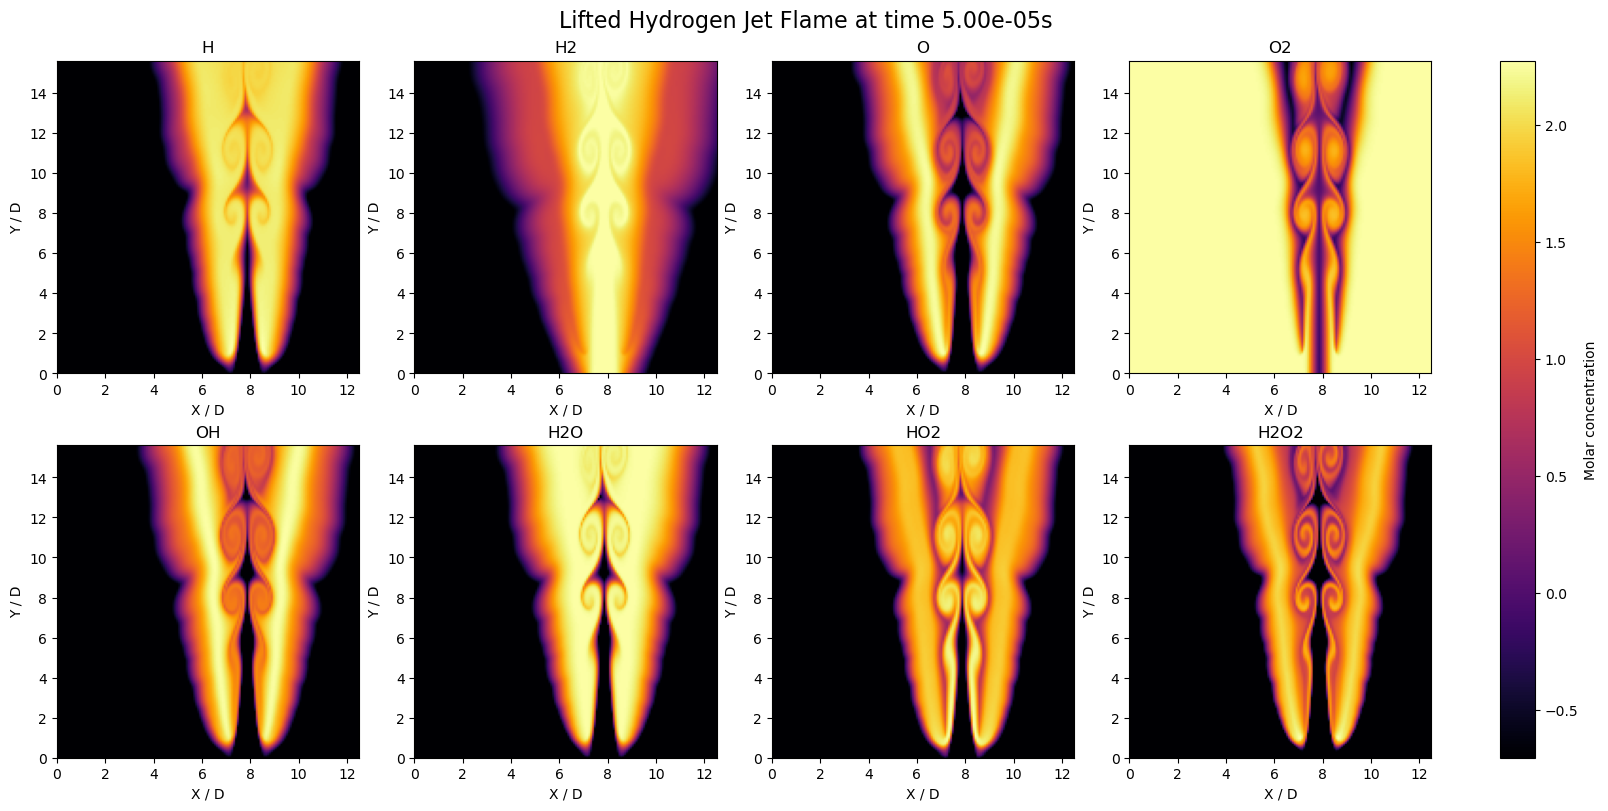

In [10]:
Lx, Ly = 12.5, 15.6        # domain size in D units
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()
tensor_plot =  tensors_scaled[list(tensors_scaled.keys())[0]]
for idx, ax in enumerate(axes):
    if idx < tensor_plot.shape[2]:
        im = ax.imshow(
            tensor_plot[:, :, idx, t],
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        ax.set_title(f"{component_names[idx][1:]}")
        ax.set_xlabel("X / D")
        ax.set_ylabel("Y / D")
    else:
        ax.axis('off')  # turn off unused axes if fewer than 8 components

fig.colorbar(im, ax=axes, orientation='vertical', label="Molar concentration")
plt.savefig(fname = 'README_PLOTS/processed_data_t10.png')
plt.show()


## PCA classica

Per prima cosa bisogna implementare la PCA nella sua forma piu' tradizionale

In [11]:
for dataset_path, tensor in tensors_scaled.items():
    X = tensor.reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
    U, sigma, V = np.linalg.svd(X, full_matrices=False)
    
    loadings = V.T  # Now shape is (n_components x n_modes)
    
    summary_data = []
    
    for mode in range(8):
        mode_vector = np.abs(loadings[:, mode])
        total = np.sum(mode_vector)
        rel_contrib = 100 * mode_vector / total if total > 0 else np.zeros_like(mode_vector)
        
        # Get top 3 species
        top3_indices = np.argsort(rel_contrib)[:][::-1]
        
        top_species = []
        for idx in top3_indices:
            top_species.append(f"{component_names[idx]} ({rel_contrib[idx]:.1f}%)")
        
        summary_data.append({
            'Mode': mode + 1,
            '1st Species': top_species[0],
            '2nd Species': top_species[1],
            '3rd Species': top_species[2],
            '4rd Species': top_species[3],
            '5rd Species': top_species[4],
            '6rd Species': top_species[5],
            '7rd Species': top_species[6],
            '8rd Species': top_species[7],
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print(f"CONTRIBUTING SPECIES FOR EACH PCA MODE - {dataset_path}")
    print("="*80)
    print(df_summary.to_string(index=False))
    print("="*80)


CONTRIBUTING SPECIES FOR EACH PCA MODE - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species   3rd Species   4rd Species  5rd Species   6rd Species  7rd Species   8rd Species
    1    YO (12.5%)  YH2 (12.5%)   YO2 (12.5%)  YH2O (12.5%)  YOH (12.5%)  YHO2 (12.5%)   YH (12.5%) YH2O2 (12.5%)
    2  YHO2 (17.2%)  YH2 (17.1%)    YO (16.8%)  YH2O (16.7%) YH2O2 (9.3%)     YH (9.1%)   YO2 (7.1%)    YOH (6.8%)
    3   YOH (18.4%)  YO2 (18.3%)    YH (16.4%) YH2O2 (16.3%)   YH2 (8.8%)   YHO2 (8.5%)  YH2O (6.8%)     YO (6.5%)
    4 YH2O2 (23.1%)   YH (23.1%)  YH2O (13.5%)    YO (13.4%)   YO2 (9.1%)    YOH (9.0%)  YHO2 (4.4%)    YH2 (4.4%)
    5    YO (14.2%) YH2O (14.0%) YH2O2 (13.3%)    YH (13.2%)  YOH (11.8%)   YO2 (11.7%) YHO2 (11.0%)   YH2 (10.8%)
    6   YH2 (17.5%) YHO2 (17.4%)   YO2 (15.7%)   YOH (15.6%)   YH (12.3%) YH2O2 (12.2%)  YH2O (4.8%)     YO (4.6%)
    7  YHO2 (18.4%)  YH2 (18.0%)  YH2O (16.7%)    YO (16.1%) YH2O2 (8.7%

(6400000, 8)
Total spatial features: 6400000

Top modes energy content:


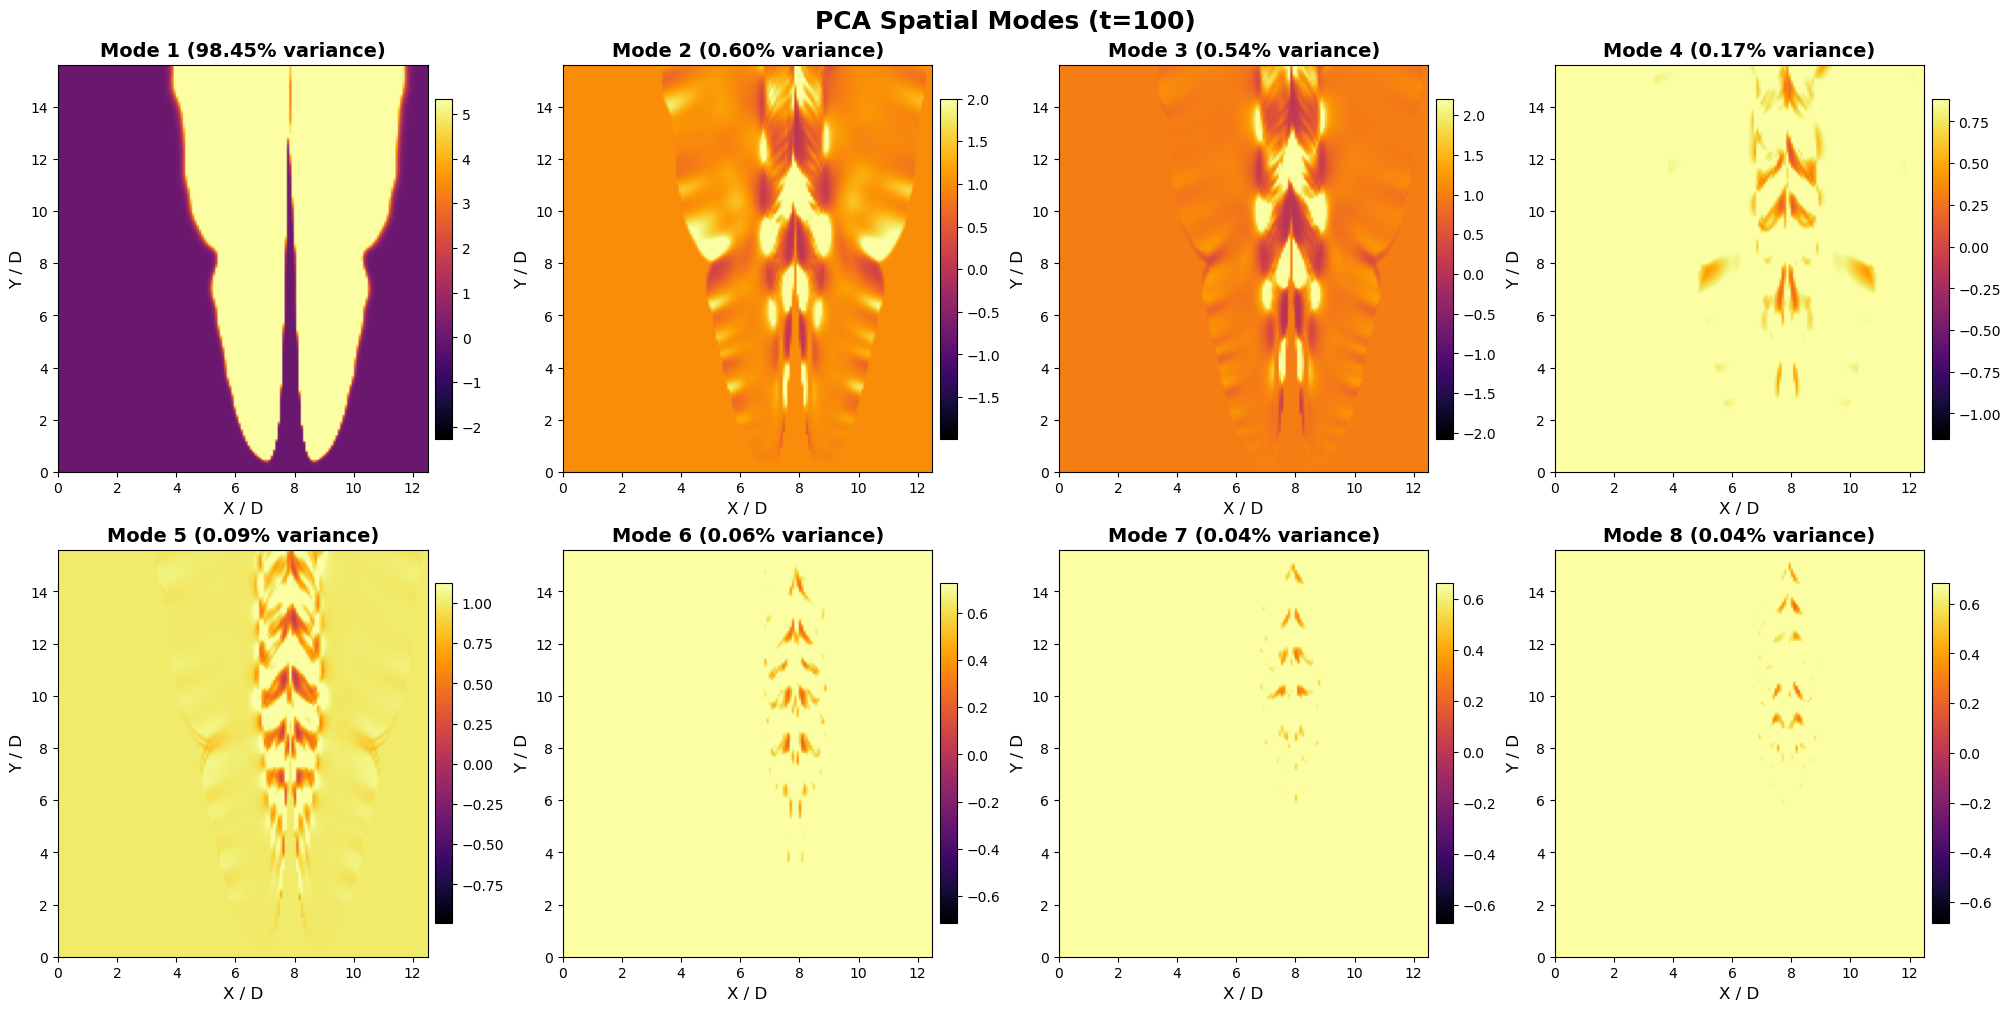

In [12]:
Phi = U
print(U.shape)
T = np.diag(sigma) @ V
energy = sigma**2
energy_fraction = energy / np.sum(energy)
print(f"Total spatial features: {X.shape[0]}")
print("\nTop modes energy content:")

Lx, Ly = 12.5, 15.6  # domain size in D units
t_snapshot = 100  

fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
fig.suptitle(f"PCA Spatial Modes (t={t_snapshot})", fontsize=18, fontweight='bold')

axes = axes.flatten()

for idx in range(8):
    phi_mode = (Phi * sigma)[:, idx].reshape(Ny_sub, Nx_sub, 200)
    phi_snapshot = np.flip(phi_mode[:, :, t_snapshot], axis=0)
    
    im = axes[idx].imshow(
        np.power(10,phi_snapshot),
        cmap='inferno',
        extent=[0, Lx, 0, Ly],
        aspect='auto',
        vmin=phi_snapshot.min(),  # Independent min
        vmax=phi_snapshot.max()   # Independent max
    )
    
    axes[idx].set_title(
        f"Mode {idx+1} ({energy_fraction[idx]*100:.2f}% variance)",
        fontsize=14,
        fontweight='bold'
    )
    axes[idx].set_xlabel("X / D", fontsize=12)
    axes[idx].set_ylabel("Y / D", fontsize=12)
    axes[idx].tick_params(labelsize=10)
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axes[idx], orientation='vertical', pad=0.02, fraction=0.046)
    cbar.ax.tick_params(labelsize=10)

plt.savefig('README_PLOTS/pca_spatial_modes_all.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_8973/786612801.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=12, loc='lower right')


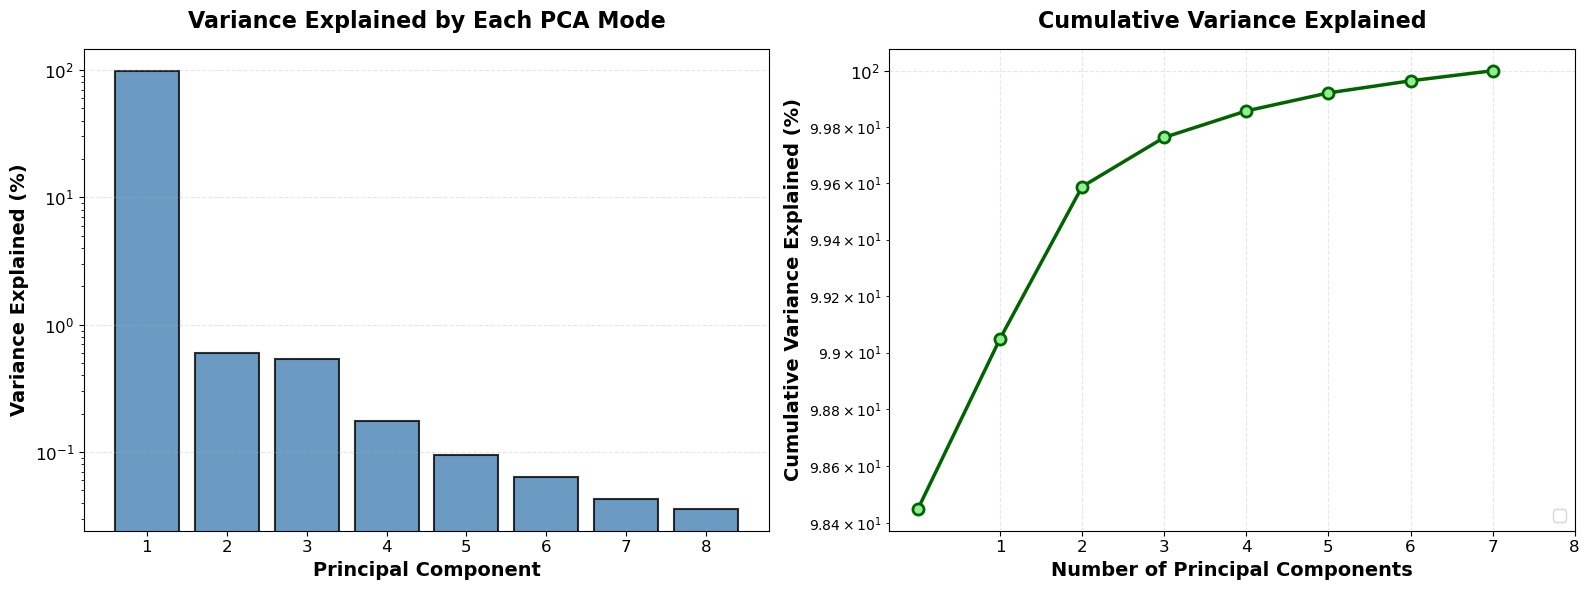


Variance Explained Summary:
  First mode: 98.45%
  First 2 modes: 99.05%
  First 3 modes: 99.59%
  First 4 modes: 99.76%


In [13]:
variance_explained = sigma**2 / np.sum(sigma**2)
cumulative_variance = np.cumsum(variance_explained)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Variance explained per mode
ax1.bar(range(1, len(variance_explained) + 1), variance_explained * 100, 
        color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Principal Component', fontsize=14, fontweight='bold')
ax1.set_ylabel('Variance Explained (%)', fontsize=14, fontweight='bold')
ax1.set_title('Variance Explained by Each PCA Mode', fontsize=16, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(labelsize=12)
ax1.set_xticks(range(1, len(variance_explained) + 1))
ax1.set_yscale("log")
# Cumulative variance explained
ax2.plot(range(0, len(cumulative_variance)), cumulative_variance * 100, 
         marker='o', markersize=8, linewidth=2.5, color='darkgreen', 
         markerfacecolor='lightgreen', markeredgewidth=2, markeredgecolor='darkgreen')
ax2.set_xlabel('Number of Principal Components', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=14, fontweight='bold')
ax2.set_title('Cumulative Variance Explained', fontsize=16, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=12, loc='lower right')
ax2.tick_params(labelsize=12)
ax2.set_xticks(range(1, len(cumulative_variance) + 1))
ax2.set_yscale("log")

plt.tight_layout()
plt.savefig('README_PLOTS/pca_variance_explained.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVariance Explained Summary:")
print(f"  First mode: {variance_explained[0]*100:.2f}%")
print(f"  First 2 modes: {cumulative_variance[1]*100:.2f}%")
print(f"  First 3 modes: {cumulative_variance[2]*100:.2f}%")
print(f"  First 4 modes: {cumulative_variance[3]*100:.2f}%")

#### RESTANO DA FARE GLI ERRORI, MA PRIMA DI SBATTERSI E' IL CASO DI CAPIRE SE VA BENE


In [14]:
decomposition_results = {}  # store factors and cores per dataset

for dataset_path, tensor in tensors_scaled.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset: {dataset_path}")
    print("=" * 100)
    
    factors = []
    for i in tqdm(range(tensor.ndim)):
        U, _, _ = np.linalg.svd(tl.unfold(tensor, mode=i), full_matrices=False)
        factors.append(U)

    core = multi_mode_dot(tensor, [U.T for U in factors], modes=range(tensor.ndim))
    print("done")
    reconst = multi_mode_dot(core, factors, modes=range(tensor.ndim))
    
    # check reconstruction accuracy
    close = np.allclose(reconst, tensor, rtol=1e-5, atol=1e-8)
    error = np.linalg.norm(np.subtract(reconst, tensor)) / np.linalg.norm(tensor)
    
    print(f"  Reconstruction close: {close}")
    print(f"  Relative reconstruction error: {error:.6e}")
    print("-" * 100)
    
    # store results
    decomposition_results[dataset_path] = {
        "core": core,
        "factors": factors,
    }

print("\n" + "=" * 100)


Performing HOSVD for dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3


100%|██████████| 4/4 [00:23<00:00,  5.77s/it]


done
  Reconstruction close: True
  Relative reconstruction error: 1.959395e-15
----------------------------------------------------------------------------------------------------



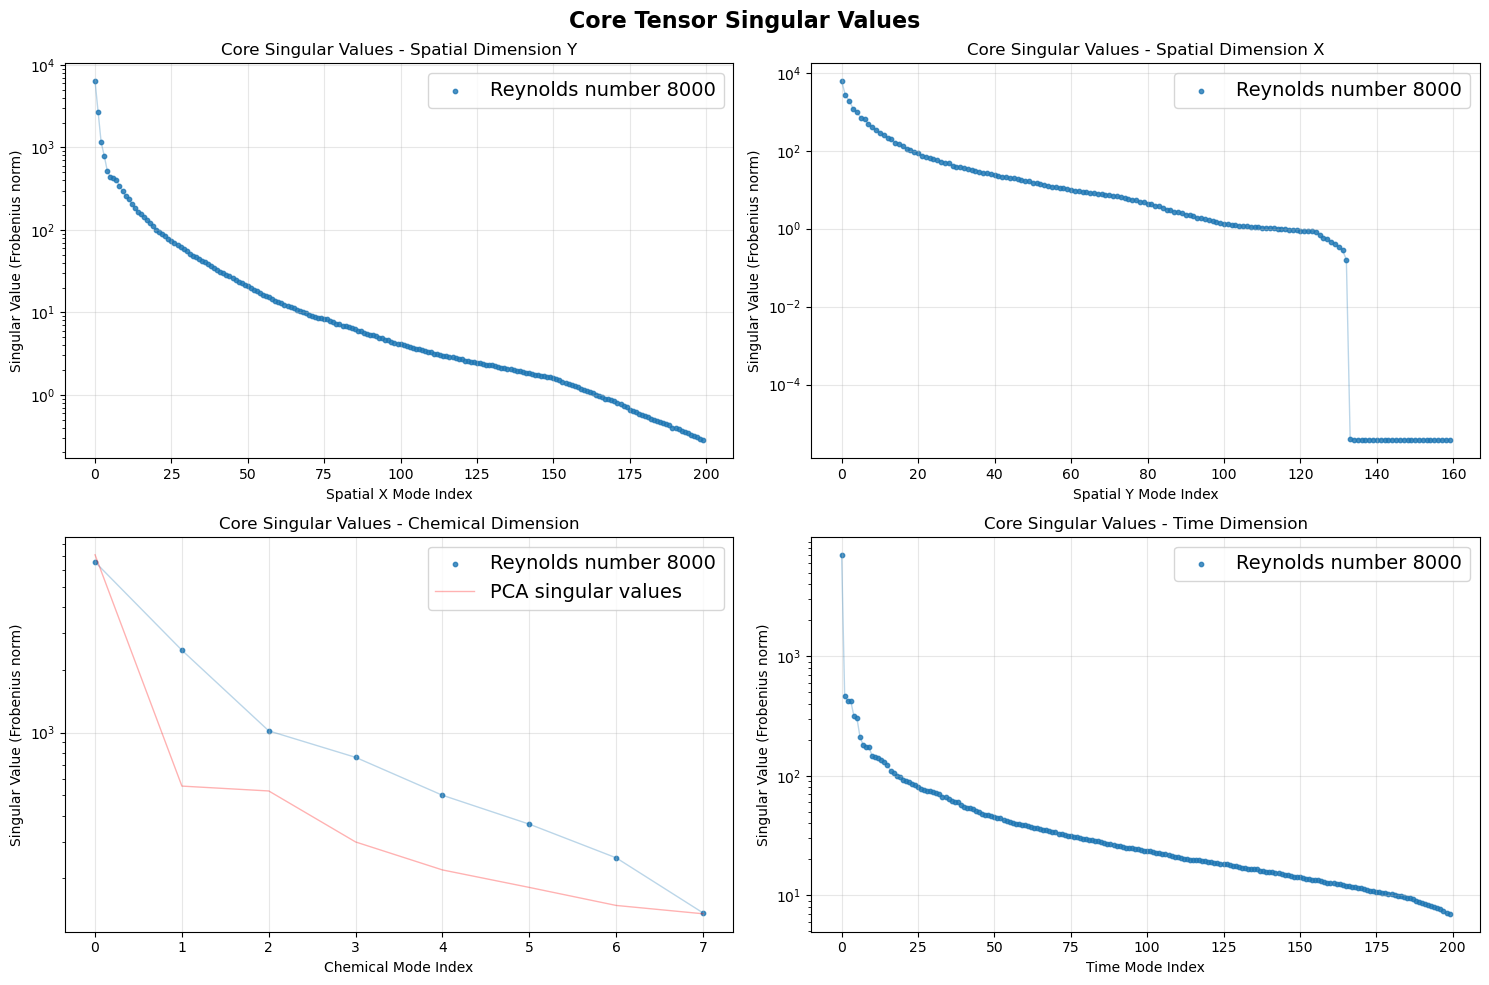

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(decomposition_results)))

for idx, (key, f) in enumerate(decomposition_results.items()):
        core = f['core']
        dataset_name = f"Reynolds number {key.split("-")[-1][:4]}"
        color = colors[idx]
        
        sv_0 = [np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])]
        ax = axes[0, 0]
        ax.scatter(range(len(sv_0)), sv_0, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_0)), sv_0, color=color, alpha=0.3, linewidth=1)
        
        sv_1 = [np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])]
        ax = axes[0, 1]
        ax.scatter(range(len(sv_1)), sv_1, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_1)), sv_1, color=color, alpha=0.3, linewidth=1)
        
        sv_chem = [np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])]
        ax = axes[1, 0]
        ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=0.3, linewidth=1)
        ax.plot(range(len(sv_chem)), sigma, color='red', alpha=0.3, linewidth=1, label="PCA singular values")
        
        sv_time = [np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])]
        ax = axes[1, 1]
        ax.scatter(range(len(sv_time)), sv_time, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_time)), sv_time, color=color, alpha=0.3, linewidth=1)

ax = axes[0, 0]
ax.set_xlabel('Spatial X Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension Y') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[0, 1]
ax.set_xlabel('Spatial Y Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension X') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 0]
ax.set_xlabel('Chemical Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Chemical Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 1]
ax.set_xlabel('Time Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Time Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

fig.suptitle('Core Tensor Singular Values', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('README_PLOTS/hosvd_core_vals.png', dpi=300, bbox_inches='tight')

plt.show()

In [16]:
# Print HOSVD loadings for all 8 species
for dataset_path, result in decomposition_results.items():
    factors = result['factors']
    U_chem = factors[2]  # Chemical dimension factor (3rd dimension)
    
    summary_data = []
    
    for mode in range(8):
        mode_vector = np.abs(U_chem[:, mode])
        total = np.sum(mode_vector)
        rel_contrib = 100 * mode_vector / total if total > 0 else np.zeros_like(mode_vector)
        
        # Get all species in descending order
        sorted_indices = np.argsort(rel_contrib)[::-1]
        
        species_data = {}
        for rank, idx in enumerate(sorted_indices):
            species_data[f'{rank+1}st Species' if rank == 0 else f'{rank+1}nd Species' if rank == 1 else f'{rank+1}rd Species' if rank == 2 else f'{rank+1}th Species'] = \
                f"{component_names[idx]} ({rel_contrib[idx]:.1f}%)"
        
        summary_data.append({
            'Mode': mode + 1,
            **species_data
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n" + "="*120)
    print(f"CONTRIBUTING SPECIES FOR EACH HOSVD MODE (Chemical Dimension) - {dataset_path}")
    print("="*120)
    print(df_summary.to_string(index=False))
    print("="*120)


CONTRIBUTING SPECIES FOR EACH HOSVD MODE (Chemical Dimension) - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species  3rd Species   4th Species  5th Species   6th Species  7th Species 8th Species
    1  YH2O (13.7%)  YOH (13.5%)   YH (13.5%)  YHO2 (13.3%)   YO (13.1%) YH2O2 (13.1%)  YH2 (12.3%)  YO2 (7.6%)
    2   YO2 (39.3%)  YH2 (15.4%)   YO (12.1%) YH2O2 (11.6%)  YHO2 (8.1%)    YOH (7.2%)    YH (4.2%) YH2O (2.1%)
    3   YH2 (33.3%)  YO2 (15.6%) YHO2 (14.8%) YH2O2 (10.8%)    YH (7.4%)    YOH (6.8%)  YH2O (6.3%)   YO (5.1%)
    4    YO (24.2%)   YH (20.4%) YHO2 (17.7%)   YOH (16.0%) YH2O2 (9.9%)    YH2 (8.1%)   YO2 (2.7%) YH2O (1.0%)
    5 YH2O2 (37.7%) YH2O (21.8%) YHO2 (11.4%)   YH2 (11.3%)    YH (8.2%)    YOH (6.2%)   YO2 (2.7%)   YO (0.7%)
    6  YHO2 (31.5%)   YH (26.7%)  YO2 (15.7%)   YH2 (12.6%)  YH2O (7.4%)     YO (3.3%) YH2O2 (2.2%)  YOH (0.6%)
    7  YH2O (34.8%)   YH (21.2%)   YO (12.6%) YH2O2 (10.7%)   YOH (8.5

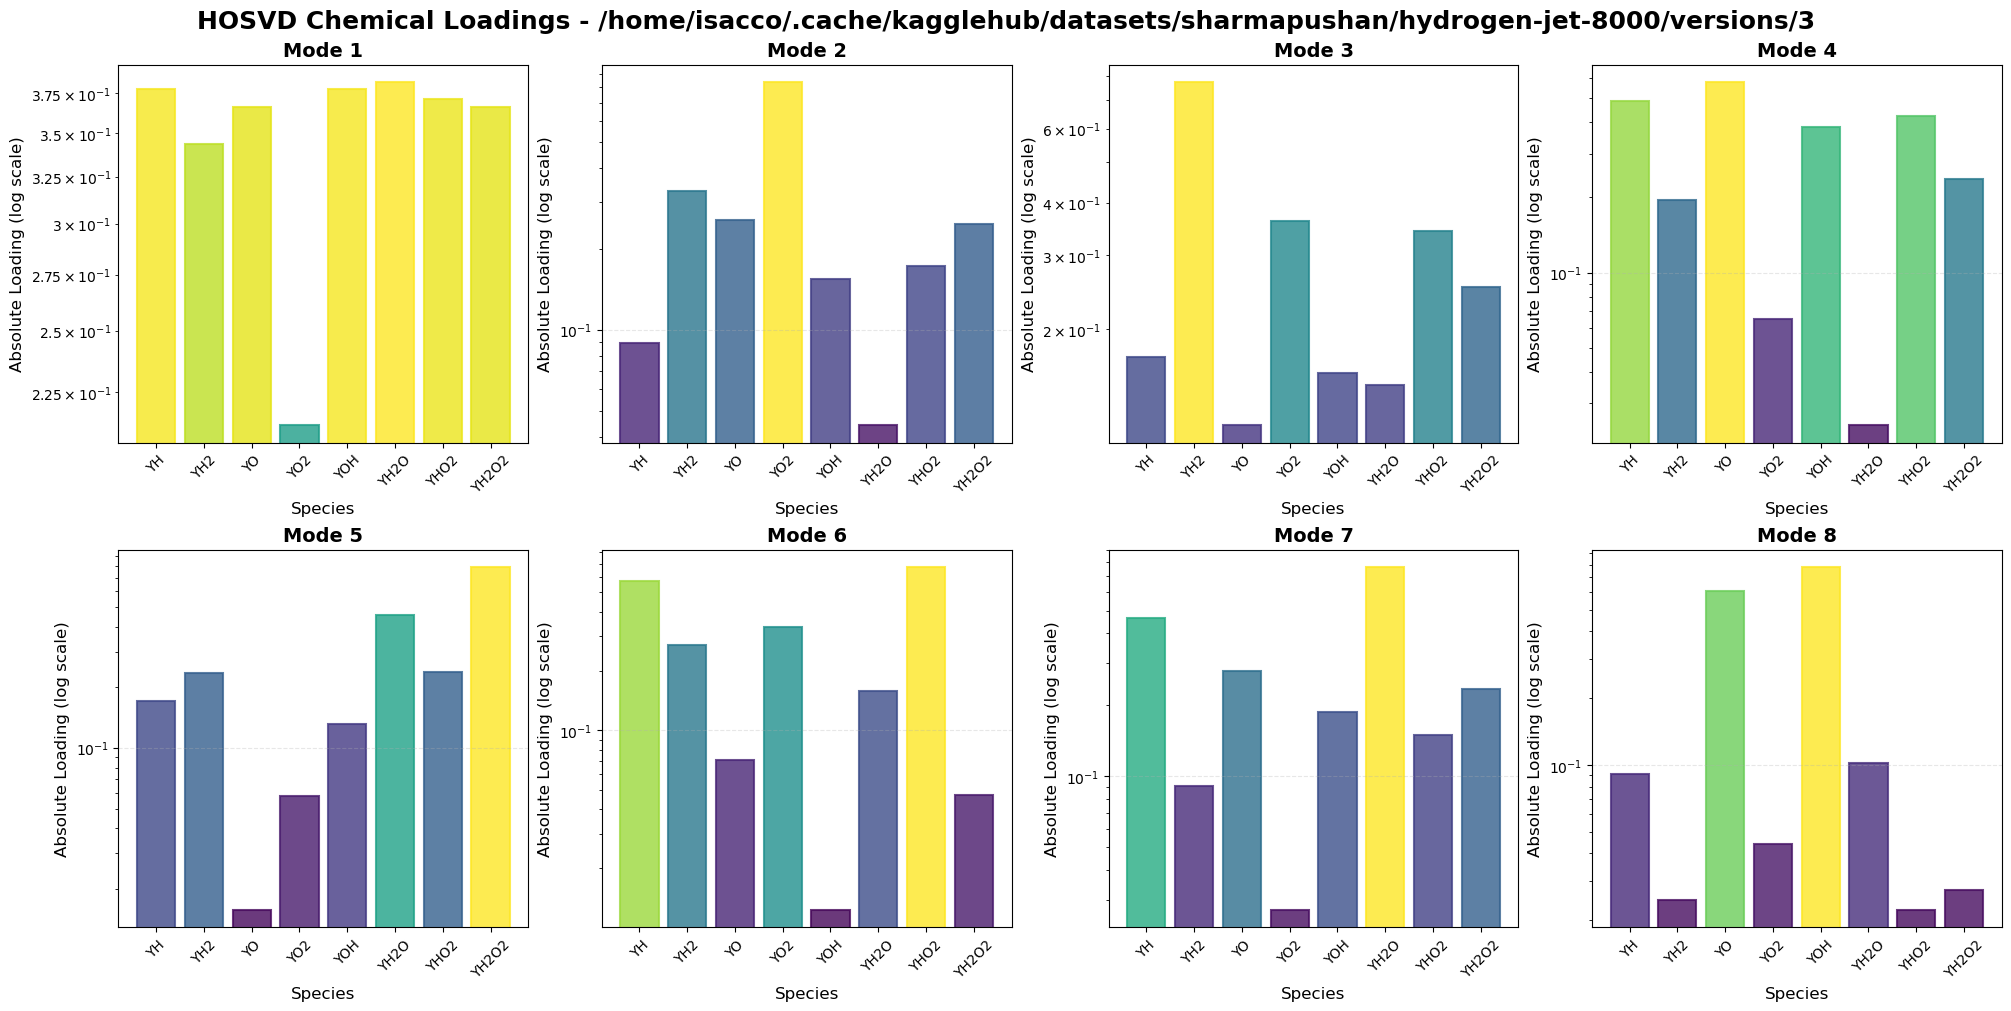

In [17]:
# Visualize HOSVD loadings for all 8 modes in a 2x4 grid
for dataset_path, result in decomposition_results.items():
    factors = result['factors']
    U_chem = factors[2]  # Chemical dimension factor (3rd dimension)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    fig.suptitle(f"HOSVD Chemical Loadings - {dataset_path}", fontsize=18, fontweight='bold')
    
    axes = axes.flatten()
    
    for mode in range(8):
        mode_vector = np.abs(U_chem[:, mode])
        
        ax = axes[mode]
        bars = ax.bar(component_names, mode_vector, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Color the bars differently based on magnitude
        colors = plt.cm.viridis(mode_vector / mode_vector.max())
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        ax.set_yscale('log')
        ax.set_title(f'Mode {mode + 1}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Species', fontsize=12)
        ax.set_ylabel('Absolute Loading (log scale)', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.savefig(f'README_PLOTS/hosvd_chemical_loadings_{dataset_path.split("/")[-1]}.png', dpi=300, bbox_inches='tight')
    plt.show()

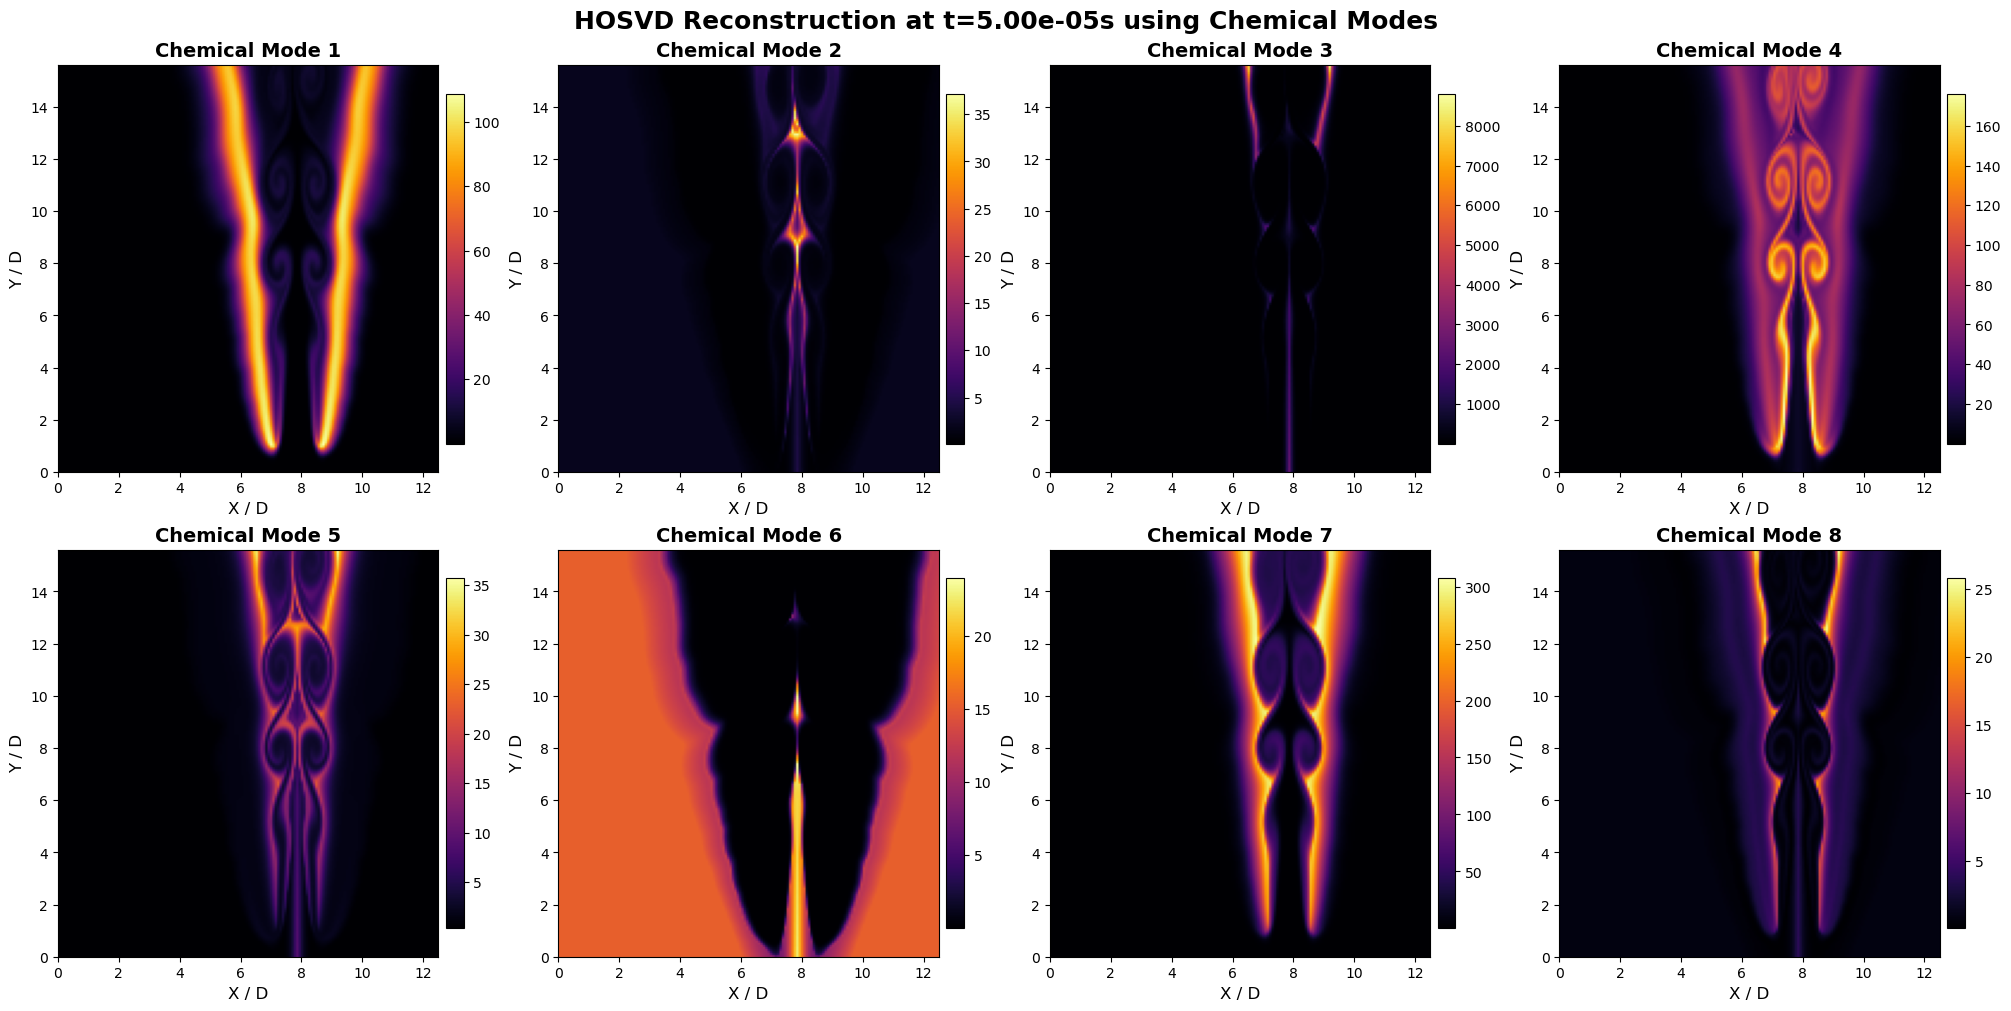

In [18]:
for dataset_path, result in decomposition_results.items():
    factors = result['factors']
    core = result['core']
    
    U_y = factors[0]      # Spatial Y factor (Ny_sub, Ny_sub)
    U_x = factors[1]      # Spatial X factor (Nx_sub, Nx_sub)
    U_chem = factors[2]   # Chemical dimension factor (8, 8)
    U_time = factors[3]   # Time factor (200, 200)
    
    t = 10  # Time snapshot
    Lx, Ly = 12.5, 15.6  # domain size in D units
    time_conversion_factor = 5e-06
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    fig.suptitle(f"HOSVD Reconstruction at t={t * time_conversion_factor:.2e}s using Chemical Modes", 
                 fontsize=18, fontweight='bold')
    
    axes = axes.flatten()
    
    for mode in range(8):
        reconstructed = multi_mode_dot(core, [U_y, U_x,U_chem[:, mode], U_time], modes=[0,1,2,3])
        reconstructed_t10 = np.power(10, reconstructed[:, :, t])        
        ax = axes[mode]
        im = ax.imshow(
            reconstructed_t10,
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        
        ax.set_title(f'Chemical Mode {mode + 1}', fontsize=14, fontweight='bold')
        ax.set_xlabel("X / D", fontsize=12)
        ax.set_ylabel("Y / D", fontsize=12)
        ax.tick_params(labelsize=10)
        
        # Add colorbar for each subplot
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, fraction=0.046)
        cbar.ax.tick_params(labelsize=10)
    
    plt.savefig(f'README_PLOTS/hosvd_reconstruction_t10_chemical_modes.png', dpi=300, bbox_inches='tight')
    plt.show()

In [28]:
import imageio
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorly.tenalg import multi_mode_dot

# ---- User variables ----
Lx, Ly = 12.5, 15.6
time_conversion_factor = 5e-06

# ---- Pre-compute HOSVD reconstructions ----
dataset_path, result = list(decomposition_results.items())[0]
factors = result['factors']
core = result['core']
U_y, U_x, U_chem, U_time = factors

print("Reconstructing HOSVD tensors for all chemical modes...")
hosvd_reconstructed_tensors = [
    multi_mode_dot(core, [U_y, U_x, U_chem[:, mode], U_time], modes=[0, 1, 2, 3]) 
    for mode in tqdm(range(8), desc="HOSVD Chemical modes")
]

# Compute global min/max for HOSVD
print("Computing min/max values for HOSVD...")
hosvd_vmin_per_mode = [tensor.min() for tensor in hosvd_reconstructed_tensors]
hosvd_vmax_per_mode = [tensor.max() for tensor in hosvd_reconstructed_tensors]
hosvd_vmin = min(hosvd_vmin_per_mode)
hosvd_vmax = max(hosvd_vmax_per_mode)
print(f"HOSVD global value range: [{hosvd_vmin:.2e}, {hosvd_vmax:.2e}]")

# Compute global min/max for PCA across all modes and time steps
print("Computing min/max values for PCA...")
pca_vmin, pca_vmax = np.inf, -np.inf
for idx in range(8):
    phi_mode = (Phi * sigma)[:, idx].reshape(Ny_sub, Nx_sub, 200)
    phi_mode_flipped = np.flip(phi_mode, axis=0)
    pca_vmin = min(pca_vmin, phi_mode_flipped.min())
    pca_vmax = max(pca_vmax, phi_mode_flipped.max())
print(f"PCA global value range: [{pca_vmin:.2e}, {pca_vmax:.2e}]")

# Create temporary directory for frames
temp_dir = 'temp_frames_comparison'
os.makedirs(temp_dir, exist_ok=True)
frames = []

print(f"Generating frames for comparison gif...")
for t_snapshot in tqdm(range(100)):  # Iterate through all time points
    t_physical = t_snapshot * time_conversion_factor
    
    # ---- Create unified figure ----
    fig, axes = plt.subplots(2, 8, figsize=(32, 10), constrained_layout=True)
    fig.suptitle(
        f"PCA vs HOSVD Modes (t = {t_physical:.2e}s)",
        fontsize=20, fontweight='bold'
    )
    
    # =============================
    # FIRST ROW: PCA SPATIAL MODES
    # =============================
    for idx in range(8):
        phi_mode = (Phi * sigma)[:, idx].reshape(Ny_sub, Nx_sub, 200)
        phi_snapshot = phi_mode[:, :, t_snapshot]
        im = axes[0, idx].imshow(
            phi_snapshot,
            cmap='inferno',
            extent=[0, Lx, 0, Ly],
            aspect='auto',
            vmin=pca_vmin,  # Global PCA minimum
            vmax=pca_vmax,   # Global PCA maximum
            origin = 'lower'
        )
        axes[0, idx].set_title(
            f"PCA Mode {idx+1}\n({energy_fraction[idx]*100:.2f}% var.)",
            fontsize=12, fontweight='bold'
        )
        axes[0, idx].set_xlabel("X / D", fontsize=10)
        axes[0, idx].set_ylabel("Y / D", fontsize=10)
        axes[0, idx].tick_params(labelsize=8)
        cbar = fig.colorbar(im, ax=axes[0, idx], orientation='vertical', pad=0.02, fraction=0.046)
        cbar.ax.tick_params(labelsize=8)
    
    # ====================================
    # SECOND ROW: HOSVD RECONSTRUCTIONS
    # ====================================
    for mode in range(8):
        reconstructed_t = hosvd_reconstructed_tensors[mode][:, :, t_snapshot]
        im = axes[1, mode].imshow(
            reconstructed_t,
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto',
            vmin=hosvd_vmin,  # Global HOSVD minimum
            vmax=hosvd_vmax   # Global HOSVD maximum
        )
        axes[1, mode].set_title(f"HOSVD Chem Mode {mode + 1}", fontsize=12, fontweight='bold')
        axes[1, mode].set_xlabel("X / D", fontsize=10)
        axes[1, mode].set_ylabel("Y / D", fontsize=10)
        axes[1, mode].tick_params(labelsize=8)
        cbar = fig.colorbar(im, ax=axes[1, mode], orientation='vertical', pad=0.02, fraction=0.046)
        cbar.ax.tick_params(labelsize=8)
    
    # Save frame
    frame_path = f'{temp_dir}/frame_{t_snapshot:03d}.png'
    plt.savefig(frame_path, dpi=150, bbox_inches='tight')
    frames.append(imageio.imread(frame_path))
    plt.close(fig)

# Create gif
gif_path = 'README_PLOTS/pca_vs_hosvd_comparison.gif'
print(f"Creating gif at {gif_path}...")
imageio.mimsave(gif_path, frames, fps=10, loop=0)

# Clean up temporary frames
print("Cleaning up temporary files...")
for file in os.listdir(temp_dir):
    os.remove(os.path.join(temp_dir, file))
os.rmdir(temp_dir)

print(f"Gif saved to {gif_path}")

Reconstructing HOSVD tensors for all chemical modes...


HOSVD Chemical modes: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Computing min/max values for HOSVD...
HOSVD global value range: [-2.84e+00, 4.04e+00]
Computing min/max values for PCA...
PCA global value range: [-1.23e+01, 6.44e+00]
Generating frames for comparison gif...


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_8973/1006488169.py:107: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))
100%|██████████| 100/100 [08:08<00:00,  4.88s/it]


Creating gif at README_PLOTS/pca_vs_hosvd_comparison.gif...
Cleaning up temporary files...
Gif saved to README_PLOTS/pca_vs_hosvd_comparison.gif


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ===== GIVEN PARAMETERS =====
D = 1.92e-3  # jet diameter in meters
T_jet = 400  # K
T_coflow = 1100  # K
P = 1e5  # Pa (1 bar)
Re_range = [5000, 6000, 7000, 8000, 9000, 10000, 11000]  # jet Reynolds numbers

# Jet composition (mole fractions)
X_H2_jet = 0.65
X_N2_jet = 0.35

# Air composition (mole fractions)
X_O2_air = 0.21
X_N2_air = 0.79

# Molecular weights (kg/kmol)
MW_H2 = 2.016
MW_N2 = 28.014
MW_O2 = 31.999
MW_air = 28.97

# Universal gas constant
R_universal = 8314.46  # J/(kmol·K)

# ===== COMPUTE JET PROPERTIES =====
# Mixture molecular weight of jet
MW_jet = X_H2_jet * MW_H2 + X_N2_jet * MW_N2
print(f"Jet mixture molecular weight: {MW_jet:.3f} kg/kmol")

# Jet density (ideal gas law: ρ = P·MW / (R·T))
rho_jet = P * MW_jet / (R_universal * T_jet)
print(f"Jet density: {rho_jet:.4f} kg/m³")

# Coflow air density
rho_coflow = P * MW_air / (R_universal * T_coflow)
print(f"Coflow density: {rho_coflow:.4f} kg/m³")

# ===== DYNAMIC VISCOSITY =====
# Sutherland's law for viscosity (simplified for mixture)
def sutherland_viscosity(T, T_ref=273.15, mu_ref=1.716e-5, S=110.4):
    """Sutherland's law for air viscosity"""
    return mu_ref * (T / T_ref)**1.5 * (T_ref + S) / (T + S)

# For H2-N2 mixture at jet conditions (approximate)
mu_jet = 1.2e-5  # Pa·s (approximate for H2-N2 at 400K)

# For air at coflow conditions
mu_coflow = sutherland_viscosity(T_coflow)
print(f"Jet viscosity: {mu_jet:.3e} Pa·s")
print(f"Coflow viscosity: {mu_coflow:.3e} Pa·s")

# ===== COMPUTE VELOCITIES FROM REYNOLDS NUMBER =====
print("\n" + "="*70)
print("JET VELOCITIES FOR DIFFERENT REYNOLDS NUMBERS")
print("="*70)

velocities = {}
for Re in Re_range:
    # Re = ρ·U·D / μ
    U_jet = Re * mu_jet / (rho_jet * D)
    velocities[Re] = U_jet
    print(f"Re = {Re:5d}  →  U_jet = {U_jet:.2f} m/s")

# ===== CHARACTERISTIC SCALES =====
print("\n" + "="*70)
print("CHARACTERISTIC SCALES")
print("="*70)

# Use Re = 8000 as representative case
Re_rep = 8000
U_rep = velocities[Re_rep]

# Convective time scale
tau_conv = D / U_rep
print(f"Convective time scale (D/U): {tau_conv*1e6:.2f} μs")

# Kolmogorov length scale (η ≈ D·Re^(-3/4))
eta_kolmogorov = D * Re_rep**(-0.75)
print(f"Kolmogorov scale estimate: {eta_kolmogorov*1e6:.2f} μm")

# Grid resolution
dx = 15e-6  # m
print(f"Grid size: {dx*1e6:.1f} μm")
print(f"Grid points per diameter: {D/dx:.0f}")
print(f"Grid/Kolmogorov ratio: {dx/eta_kolmogorov:.2f}")

# Domain size
Lx = 12.5 * D
Ly = 15.6 * D
print(f"\nDomain size: {Lx*1e3:.2f} mm x {Ly*1e3:.2f} mm")
print(f"Domain size: {Lx*1e6:.0f} μm x {Ly*1e6:.0f} μm")

# ===== DAMKÖHLER NUMBER ESTIMATE =====
print("\n" + "="*70)
print("DAMKÖHLER NUMBER ESTIMATE")
print("="*70)

# Chemical time scale (order of magnitude for H2-air combustion)
# H + O2 → OH + O is fast: k ≈ 1e14 exp(-16000/T) cm³/mol/s at flame temp ~2000K
T_flame_est = 2000  # K
tau_chem_est = 1e-6  # s (1 μs is typical for H2 at high T)

Da = tau_conv / tau_chem_est
print(f"τ_convective = {tau_conv*1e6:.2f} μs")
print(f"τ_chemical (estimated) = {tau_chem_est*1e6:.2f} μs")
print(f"Damköhler number (Da = τ_conv/τ_chem) ≈ {Da:.1f}")

if Da > 1:
    print("→ Da > 1: Chemistry is fast, flame is mixing-controlled")
    print("→ Explains tight coupling of species in PCA Mode 1!")
else:
    print("→ Da < 1: Slow chemistry, finite-rate effects important")

# ===== MIXTURE FRACTION =====
print("\n" + "="*70)
print("MIXTURE FRACTION CALCULATION FROM DATA")
print("="*70)

print("""
To compute mixture fraction Z from your species data:

Z = (Y_H - Y_H,ox) / (Y_H,fuel - Y_H,ox)

where Y_H is the elemental hydrogen mass fraction:
Y_H = (MW_H / MW_species) × (n_H_atoms × Y_species)

For H2-air system:
Y_H = 2×(1/2.016)×Y_H2 + 1×(1/18.015)×Y_H2O + 1×(1/17.007)×Y_OH + 
      1×(1/1.008)×Y_H + 1×(1/34.015)×Y_H2O2 + 1×(1/33.007)×Y_HO2

At jet (Z=1): Y_H,fuel = 2×(1/2.016)×(0.65×2.016/11.106) = 0.117
At coflow (Z=0): Y_H,ox = 0

Therefore: Z = Y_H / 0.117
""")

# ===== STOICHIOMETRIC MIXTURE FRACTION =====
# H2 + 0.5 O2 → H2O
# For 65% H2, 35% N2 vs 21% O2, 79% N2
nu_O2 = 0.5  # stoichiometric coefficient

# Mass-based stoichiometry
s = nu_O2 * MW_O2 / MW_H2  # oxygen-to-fuel mass ratio
Y_O2_ox = X_O2_air * MW_O2 / MW_air
Y_fuel_fuel = X_H2_jet * MW_H2 / MW_jet

Z_st = Y_O2_ox / (s * Y_fuel_fuel + Y_O2_ox)
print(f"Stoichiometric mixture fraction: Z_st = {Z_st:.4f}")

# ===== COMPUTE FROM YOUR TENSOR DATA =====
print("\n" + "="*70)
print("CODE TO COMPUTE FROM YOUR DATA")
print("="*70)

code_example = """
# Assuming you have your tensor: (Ny, Nx, n_species, n_time)
# and component_names = ['YH2O2', 'YHO2', 'YH2O', 'YOH', 'YO2', 'YO', 'YH2', 'YH']

# Molecular weights
MW = {
    'YH2': 2.016, 'YH2O': 18.015, 'YOH': 17.007, 'YH': 1.008,
    'YO2': 31.999, 'YO': 15.999, 'YH2O2': 34.015, 'YHO2': 33.007
}

# Hydrogen atoms in each species
H_atoms = {
    'YH2': 2, 'YH2O': 2, 'YOH': 1, 'YH': 1,
    'YO2': 0, 'YO': 0, 'YH2O2': 2, 'YHO2': 1
}

# Compute elemental hydrogen mass fraction
Y_H = np.zeros_like(tensor[:,:,0,:])
for idx, species in enumerate(component_names):
    Y_H += H_atoms[species] * (1.008 / MW[species]) * tensor[:,:,idx,:]

# Mixture fraction
Y_H_fuel = 0.117  # computed above
Z = Y_H / Y_H_fuel
Z = np.clip(Z, 0, 1)  # physically constrained to [0,1]

# Now you can analyze PCA modes colored by Z, temperature, etc.
"""

print(code_example)

plt.show()

Jet mixture molecular weight: 11.115 kg/kmol
Jet density: 0.3342 kg/m³
Coflow density: 0.3168 kg/m³
Jet viscosity: 1.200e-05 Pa·s
Coflow viscosity: 4.394e-05 Pa·s

JET VELOCITIES FOR DIFFERENT REYNOLDS NUMBERS
Re =  5000  →  U_jet = 93.50 m/s
Re =  6000  →  U_jet = 112.20 m/s
Re =  7000  →  U_jet = 130.90 m/s
Re =  8000  →  U_jet = 149.60 m/s
Re =  9000  →  U_jet = 168.30 m/s
Re = 10000  →  U_jet = 187.00 m/s
Re = 11000  →  U_jet = 205.71 m/s

CHARACTERISTIC SCALES
Convective time scale (D/U): 12.83 μs
Kolmogorov scale estimate: 2.27 μm
Grid size: 15.0 μm
Grid points per diameter: 128
Grid/Kolmogorov ratio: 6.61

Domain size: 24.00 mm x 29.95 mm
Domain size: 24000 μm x 29952 μm

DAMKÖHLER NUMBER ESTIMATE
τ_convective = 12.83 μs
τ_chemical (estimated) = 1.00 μs
Damköhler number (Da = τ_conv/τ_chem) ≈ 12.8
→ Da > 1: Chemistry is fast, flame is mixing-controlled
→ Explains tight coupling of species in PCA Mode 1!

MIXTURE FRACTION CALCULATION FROM DATA

To compute mixture fraction Z from 